# Front-prop: simple patterns
Front-prop demo on simple patterns: a single fully-connected layer learning through inference.

In [1]:
%load_ext autoreload
%autoreload 2

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.autonotebook import tqdm

import fp_modules as fp
from utils.fp_utils import sphere_rnd_gen, shanon_entropy_binned, plot_matrix
from utils.fp_datasets import SimplePatterns

In [65]:
# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the CPU


In [ ]:
# Disable gradients in torch - Frontprop does not need them.
torch.set_grad_enabled(False)

In [66]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


## Learn simple patterns

Create a single linear layer of Frontprop and continously feed patterns, in random order, from a set of few synthetic random patterns.
For visualisation purposes we interpret them as 2D square matrices, but the layer is fully connected and treats them as 1D vectors.

Let's see if neurons converge to those patterns and if there's preference for some patterns over others, i.e. if there's bias in coverage of patterns (statistical analysis from 100 runs further below).

You can also change the probabilities of each pattern, as well as add random noise to them, to see how they impact convergence and coverage.

In [67]:

def single_layer_frontprop_run(in_size, out_size, iterations, patterns_probs, pattern_noise, device, reports_count=5):
    
    reports_interval = 0 if reports_count == 0 else int(iterations / reports_count)

    layer = fp.FpLinear(in_size, out_size, device=device)

    if reports_interval > 0:
        print("\n----------------\nRunning frontprop on following patterns:")
        plot_matrix(dims, *SimplePatterns.get_all_patterns())
        print(f"Pattern's probabilities:\n{patterns_probs}\n\n")

    with torch.no_grad():
        for i in range(iterations):
    
            input = SimplePatterns.get_simple_pattern(patterns_probs, noise=pattern_noise) \
                .to(device).flatten().unsqueeze(0)
    
            out = layer.forward(input)
    
            if reports_interval > 0 and i % reports_interval == 0:
                print(f"\n --- Iter #{i} - neurons weights --- ")
                plot_matrix(dims, *([layer.weight[i] for i in range(neurons)]))
                # print("Layer outputs:")
                # print(out)
                # print("for input")
                # plot_matrix(DIMS, input)
    
    if reports_interval > 0:
        print(f"\n --- Final neurons weights --- ")
        plot_matrix(dims, *([layer.weight[i] for i in range(neurons)]))

    return layer




----------------
Running frontprop on following patterns:


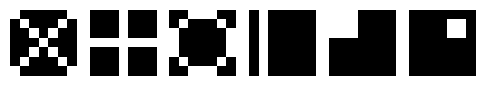

Pattern's probabilities:
[0.17 0.17 0.17 0.17 0.17 0.17]



 --- Iter #0 - neurons weights --- 


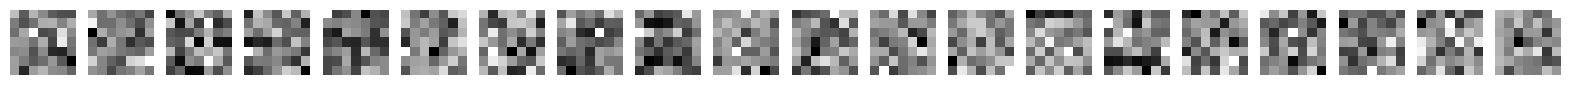


 --- Iter #4000 - neurons weights --- 


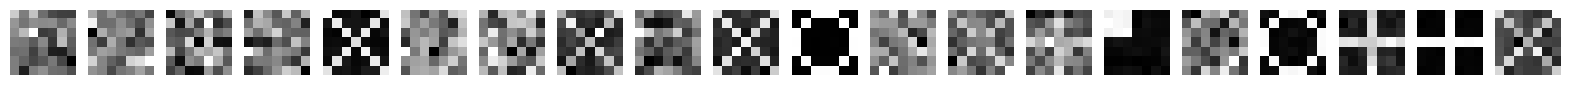


 --- Iter #8000 - neurons weights --- 


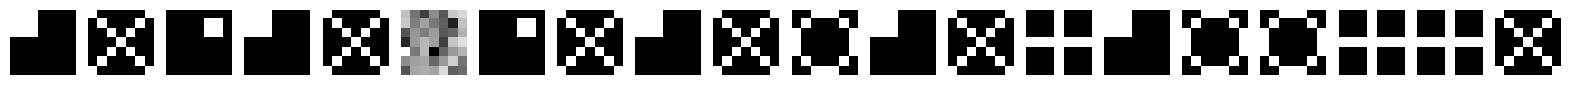


 --- Iter #12000 - neurons weights --- 


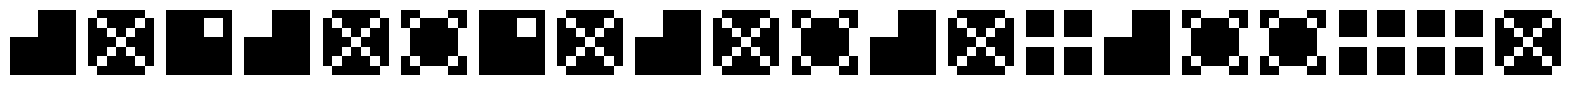


 --- Iter #16000 - neurons weights --- 


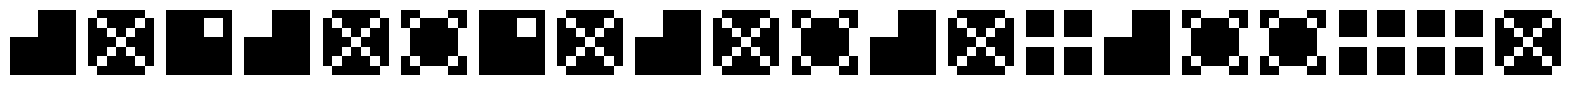


 --- Final neurons weights --- 


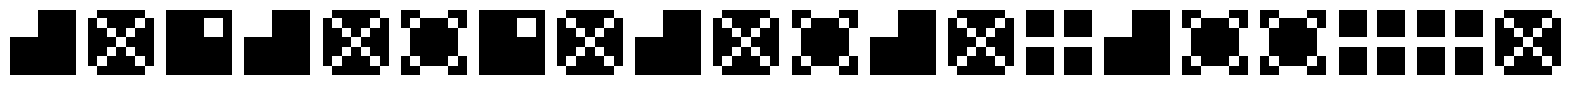

In [68]:
dims = SimplePatterns.get_pattern_dims()
iters = 20000  # 50000
neurons = 20

# optionally apply small amount of gaussian noise to patterns
noise_rate = 0.0

# define patterns frequency weights (will be normalized to sum to 1)
# change these to see the impact of frequency on neurons specialisation
pattern_probs = [1.0] * SimplePatterns.get_all_patterns_count()  # [10,1,1,1,1,1]
pattern_probs /= np.sum(pattern_probs)

# train the Front-prop layer
layer = single_layer_frontprop_run(dims[0] * dims[1],
                                   neurons,
                                   iters,
                                   pattern_probs,
                                   noise_rate,
                                   device, reports_count=5)



## Neurons activations per pattern

Pattern #0 (prob=0.17):


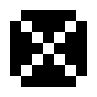

Neuron activations:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


Pattern #1 (prob=0.17):


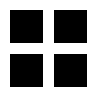

Neuron activations:
tensor([0.3780, 0.0000, 0.3780, 0.0000, 0.0000, 0.0000, 0.3780, 0.0000, 0.0000,
        0.3780, 0.0000, 0.3780, 0.0000, 0.3780, 0.0000, 0.0000, 0.3780, 0.0000,
        0.0000, 0.0000])


Pattern #2 (prob=0.17):


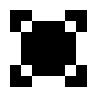

Neuron activations:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.7071,
        0.0000, 0.0000])


Pattern #3 (prob=0.17):


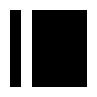

Neuron activations:
tensor([0.0000, 0.5774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000, 0.0000,
        0.0000, 0.0000])


Pattern #4 (prob=0.17):


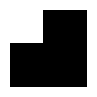

Neuron activations:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.7071])


Pattern #5 (prob=0.17):


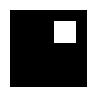

Neuron activations:
tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])


In [99]:
for i, p in enumerate(SimplePatterns.get_all_patterns(len(pattern_probs))):
    input = p.to(device).flatten().unsqueeze(0)
    out = layer.forward(input)

    print(f"Pattern #{i} (prob={round(pattern_probs[i], 2)}):")
    plot_matrix(dims, p)
    print(f"Neuron activations:\n{out.squeeze()}")
    plot_matrix((1, layer.get_size()[1]), out)

## Statistical analysis of neuron activations

In [69]:
def activation_stats_per_pattern(layer, device):
    stats_per_pattern = []
    for p in SimplePatterns.get_all_patterns(len(pattern_probs)):
        input = p.to(device).flatten().unsqueeze(0)
        out = layer.forward(input)

        # count active neurons
        active_count = torch.count_nonzero(out)
        # get average activation
        avg_activation = torch.mean(out)

        stats_per_pattern.append([active_count.item(), avg_activation.item()])
        
    return stats_per_pattern


In [70]:
# run N training runs to analyse activations per pattern

TRAIN_RUNS = 100  # FIXME 100

activation_stats = []

for i in tqdm(range(TRAIN_RUNS)):
    layer = single_layer_frontprop_run(dims[0] * dims[1], neurons, iters, pattern_probs, noise_rate, device, reports_count=0)
    activation_stats.append(activation_stats_per_pattern(layer, device))

activation_stats = np.nan_to_num(np.array(activation_stats))

assert activation_stats.shape == (TRAIN_RUNS, SimplePatterns.get_all_patterns_count(), 2)



  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
active_count_per_pattern = activation_stats[:, :, 0]
avg_activation_per_pattern = activation_stats[:, :, 1]

Patterns: #0 to #5


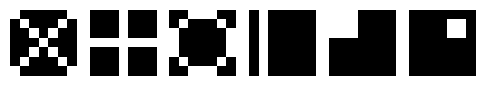

In [91]:
print(f"Patterns: #0 to #{len(pattern_probs)-1}")
plot_matrix(dims, *SimplePatterns.get_all_patterns(len(pattern_probs)))

Active neurons count per pattern:
          #0   #1   #2   #3   #4   #5
Mean:	 [3.76 4.10 3.66 3.95 3.53 4.08]
Std:	 [3.60 3.32 3.25 3.98 2.88 2.73]
Median:	 [3.00 4.00 3.00 3.00 3.00 4.00]


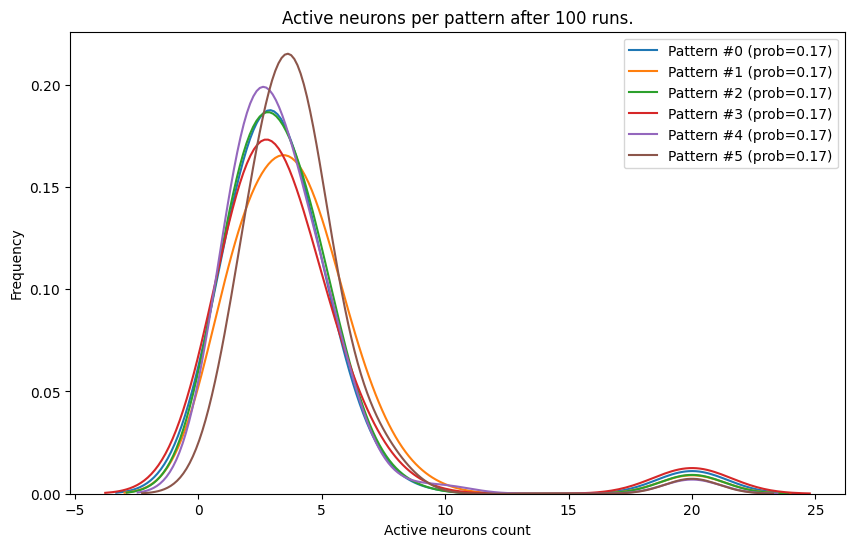

In [102]:
print("Active neurons count per pattern:")
print("          #0   #1   #2   #3   #4   #5")
print("Mean:\t",    np.mean(active_count_per_pattern, axis=0))
print("Std:\t",     np.std(active_count_per_pattern, axis=0))
print("Median:\t",  np.median(active_count_per_pattern, axis=0))

plt.figure(figsize=(10, 6))

for i in range(SimplePatterns.get_all_patterns_count()):
    # plt.hist(active_count_per_pattern[:, i], bins=NEURONS, histtype='step', linewidth=2, label=f'Pattern #{i}')
    # sns.histplot(active_count_per_pattern[:, i], bins=NEURONS, linewidth=2, label=f'Pattern #{i}', kde=True)
    sns.kdeplot(active_count_per_pattern[:, i], label=f'Pattern #{i} (prob={round(pattern_probs[i], 2)})')

plt.xlabel('Active neurons count')
plt.ylabel('Frequency')
plt.title(f'Active neurons per pattern after {TRAIN_RUNS} runs.')
plt.legend()
plt.show()

Activation strength per pattern:
          #0   #1   #2   #3   #4   #5
Mean:	 [0.08 0.09 0.08 0.08 0.08 0.09]
Std:	 [0.03 0.03 0.03 0.03 0.03 0.02]
Median:	 [0.09 0.10 0.09 0.09 0.09 0.10]


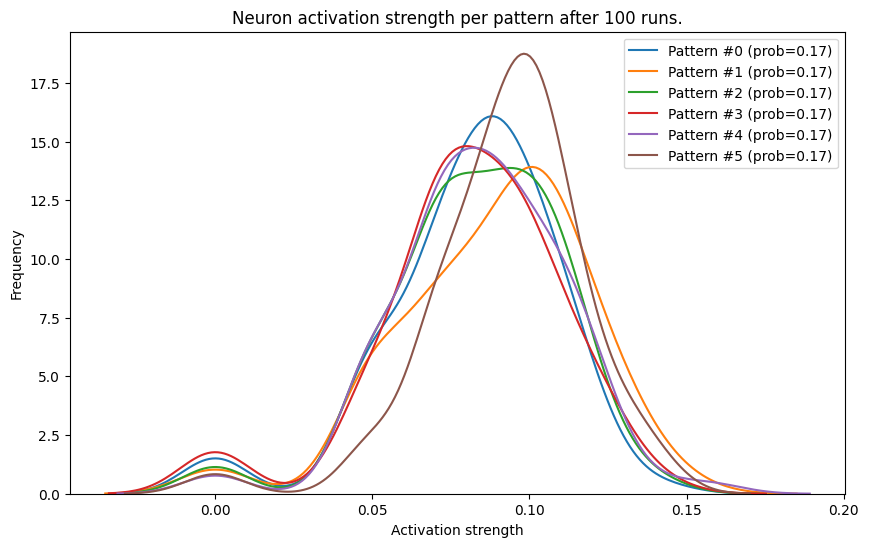

In [103]:
print("Activation strength per pattern:")
print("          #0   #1   #2   #3   #4   #5")
print("Mean:\t",    np.mean(avg_activation_per_pattern, axis=0))
print("Std:\t",     np.std(avg_activation_per_pattern, axis=0))
print("Median:\t",  np.median(avg_activation_per_pattern, axis=0))

plt.figure(figsize=(10, 6))

for i in range(SimplePatterns.get_all_patterns_count()):
    # plt.hist(avg_activation_per_pattern[:, i], bins=NEURONS, histtype='step', linewidth=2, label=f'Pattern #{i}')
    # sns.histplot(avg_activation_per_pattern[:, i], bins=NEURONS, linewidth=2, label=f'Pattern #{i}', kde=True)
    sns.kdeplot(avg_activation_per_pattern[:, i], label=f'Pattern #{i} (prob={round(pattern_probs[i], 2)})')

plt.xlabel('Activation strength')
plt.ylabel('Frequency')
plt.title(f'Neuron activation strength per pattern after {TRAIN_RUNS} runs.')
plt.legend()
plt.show()

## Conclusion

Front-prop robustly learns all patterns: neurons specialise in detecting different patterns in a balanced way - there's no strong bias towards any specific pattern attracting the majority of neurons.

On average, the number of activated neurons is similar for all patterns and does not depend on pattern frequency, or the number of ones/zeros in the pattern.

Even with pattern frequency imbalance of 10:1, the network is not affected and learns all patterns.

Noise does not affect convergence, but larger amount of noise do slow down learning (as expected).

TODO: plot those two effects (activation imbalance vs pattern probs imbalance; noise vs learning speed)
